In [1]:
from mlflow.tracking import MlflowClient
import mlflow
import sys
import os
import numpy as np
import pandas as pd

levels = 1
sys.path.append(os.path.abspath(os.path.join(".", "../"*levels)))

from scenario_utils.scenarios import Scenarios_Client
import forecast_utils as utils

# Set the tracking URI to the directory where mlruns is located
tracking_uri = "file:///Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/mlruns"
mlflow.set_tracking_uri(tracking_uri)

client = MlflowClient()

pd.options.display.max_columns = 1000

## Making Scenarios' Inputs

In [2]:
### Daily Regressor Scenarios:

# Getting variables
temperature = utils.make_daily_regressors_df(initial_date='2015-01-01')[1]
temperature = temperature[temperature['ds'] < '2031-04-01']
cdd = temperature[['ds', 'cdd']].copy()
hdd = temperature[['ds', 'hdd']].copy()
temperature = temperature[['ds', 'temperature']]

# Temperature:
col = 'temperature'
max_std_dev = 0.5  # Adjust this to control the initial variance
index = temperature[temperature['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(temperature) - index_plus
weather_factors = []

for x in range(20):
  temperature.loc[:index, col+'_'+str(x+1)] = temperature.loc[:index, 'temperature'].copy()
  random_factors = np.array([np.random.normal(loc=1, scale=max_std_dev * (i/remaining)) for i in range(remaining)])
  weather_factors.append(random_factors)
  temperature.loc[index_plus:, col+'_'+str(x+1)] = temperature.loc[index_plus:, 'temperature'].values * random_factors

temperature = temperature.drop(columns=col)

# Heating Degree Days:
col = 'hdd'
max_std_dev = 0.5  # Adjust this to control the initial variance
index = hdd[hdd['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(hdd) - index_plus

for x in range(20):
  hdd.loc[:index, col+'_'+str(x+1)] = hdd.loc[:index, 'hdd'].copy()
  hdd.loc[index_plus:, col+'_'+str(x+1)] = hdd.loc[index_plus:, 'hdd'].values * weather_factors[x]

hdd = hdd.drop(columns=col)

# Cooling Degree Days:
col = 'cdd'
max_std_dev = 0.5  # Adjust this to control the initial variance
index = cdd[cdd['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(cdd) - index_plus

for x in range(20):
  cdd.loc[:index, col+'_'+str(x+1)] = cdd.loc[:index, 'cdd'].copy()
  cdd.loc[index_plus:, col+'_'+str(x+1)] = cdd.loc[index_plus:, 'cdd'].values * weather_factors[x]

cdd = cdd.drop(columns=col)

In [ ]:
# Monthly Regressor Scenarios:

gdp = pd.read_parquet("../data/regressors/gdp.parquet")
col = 'gdp'
max_std_dev = 0.01  # Adjust this to control the initial variance
index = gdp[gdp['ds'] == '2023-08-01'].index[0]
index_plus = index + 1
remaining = len(gdp) - index_plus

for x in range(20):
  gdp.loc[:index, col+'_'+str(x+1)] = gdp.loc[:index, 'gdp'].copy()
  random_factors = np.array([np.random.normal(loc=1, scale=max_std_dev * (i/remaining)) for i in range(remaining)])
  gdp.loc[index_plus:, col+'_'+str(x+1)] = gdp.loc[index_plus:, 'gdp'].values * random_factors

gdp = gdp.drop(columns=col)

## Loading mlflow Models:

In [4]:
# Loading Monthly Model.
model_name = "gb_non_dom_monthly"
model = client.get_registered_model(model_name)
monthly_model = mlflow.pyfunc.load_model(f"models:/{model.name}/{list(model.aliases.values())[0]}")

# Loading Daily Model.
model_name = "gb_non_dom_daily"
model = client.get_registered_model(model_name)
daily_model = mlflow.pyfunc.load_model(f"models:/{model.name}/{list(model.aliases.values())[0]}")

# Working using the Scenarios_Client Object

In [5]:
scenarios = Scenarios_Client(granular_model=daily_model, monthly_model=monthly_model, mlflow_uri=tracking_uri)

scenarios.add_variable(variable_df=gdp, variable_name='gdp')
scenarios.add_variable(variable_df=temperature, variable_name='temperature')
scenarios.add_variable(variable_df=hdd, variable_name='hdd')
scenarios.add_variable(variable_df=cdd, variable_name='cdd')

scenarios.variables_pairing(variables=['temperature', 'hdd', 'cdd'])
scenarios_df = scenarios.create_scenarios()

In [6]:
scenarios.run_one_scenario(scenario_number=10)

/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:165: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['abnormal'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:167: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['covid_1'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:169: FutureWarning: The behavior of 'isin' with dtype=datetim

,granular_ds,granular_temperature,granular_nominal_temperature,granular_hdd,granular_nominal_hdd,granular_cdd,granular_nominal_cdd,gdp,nominal_gdp,scenario_yhat
0,2015-01-01,-0.002641,9.994652,-0.013125,803.921260,-0.00095,0.0,-0.048796,91.687000,388.669565
1,2015-01-02,-0.017001,6.967103,0.025706,1949.742425,-0.00095,0.0,-0.048796,91.687000,473.125268
2,2015-01-03,-0.028726,4.495221,0.057329,2882.854784,-0.00095,0.0,-0.048796,91.687000,495.589845
3,2015-01-04,-0.040889,1.930792,0.090667,3866.575854,-0.00095,0.0,-0.048796,91.687000,468.827635
4,2015-01-05,-0.017712,6.817229,0.027077,1990.184090,-0.00095,0.0,-0.048796,91.687000,601.507937
...,...,...,...,...,...,...,...,...,...,...
5929,2031-03-27,-0.012218,7.975484,0.049514,2652.255784,-0.00095,0.0,0.203873,118.816052,416.511563
5930,2031-03-28,-0.024592,5.366727,0.009690,1477.153288,-0.00095,0.0,0.203873,118.816052,384.772303
5931,2031-03-29,-0.019784,6.380445,0.023349,1880.185852,-0.00095,0.0,0.203873,118.816052,331.681781
5932,2031-03-30,-0.038187,2.500457,-0.012496,822.474601,-0.00095,0.0,0.203873,118.816052,288.405778


In [7]:
scenarios_output = scenarios.run_all_scenarios()

/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:165: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['abnormal'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:167: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  covid_binary['covid_1'] = covid_binary['ds'].isin(
/Users/pabloparedes/Documents/prophet_GB_demand_forecasting_workflow/forecast_utils/external_variables.py:169: FutureWarning: The behavior of 'isin' with dtype=datetim

<Axes: xlabel='granular_ds'>

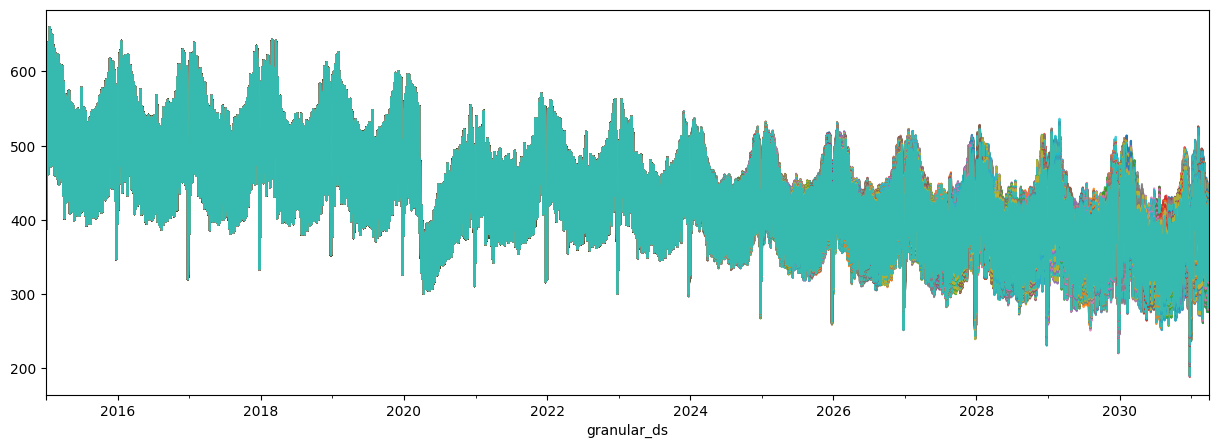

In [8]:
scenarios_output.pivot(index='granular_ds', columns='scenario_number', values='scenario_yhat').plot(figsize=(15,5), alpha=0.8, legend=False)